In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

from PIL import Image
from nltk.translate import bleu_score

# Import Custom Module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

[]

***

In [3]:
from src.utils.config import IMAGES_DIR
from src.utils.sets import (
    load_raw_image_description_map, init_image_descriptions_map,
    init_word2idx, init_idx2word, load_set_images, init_image_descriptions_set,
    load_image_embedding_map, data_generator
)

from src.utils.image import load_image
from src.utils.sequence import clean, load_word_embedding_map

from src.nn import InceptionV3Encoder, TopImageEncoder, SequenceDecoder, NeuralImageCaptioning, NICInference

***

## Understanding and formating the data

In [4]:
raw_image_description = load_raw_image_description_map()

print('\n'.join(raw_image_description[:10]))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


In [5]:
image_descriptions = init_image_descriptions_map()

image_descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [6]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [7]:
for img_name, descriptions in image_descriptions.items():
    image_descriptions[img_name] = [clean(descr) for descr in descriptions]

In [8]:
image_descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [9]:
vocabulary = set()

for key in image_descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image_descriptions[key]]

In [10]:
vocabulary.update('0')
vocabulary.update(['<START>'])
vocabulary.update(['<END>'])

In [11]:
print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 8767


### Sort the Vocabulary lexically

In [12]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [13]:
word2idx = init_word2idx(vocabulary)
idx2word = init_idx2word(vocabulary)

In [14]:
word2idx['dog']

2224

In [15]:
idx2word[2224]

'dog'

***

## Max Description Length

In [16]:
descriptions = []

for key, val in image_descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [17]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [18]:
max_description_length = len(longets_description.split()) + 2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 37


***

## Train/Dev/Test split

In [19]:
train_images = load_set_images('train')
dev_images = load_set_images('dev')
test_images = load_set_images('test')

print('Train size: {}'.format(len(train_images)))
print('Dev size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dev size: 1000
Test size: 1000


### Init Image->Descriptions Maps

In [20]:
train_image_descriptions = init_image_descriptions_set(train_images, image_descriptions)
dev_image_descriptions = init_image_descriptions_set(dev_images, image_descriptions)
test_image_descriptions = init_image_descriptions_set(test_images, image_descriptions)

print('Train size: {}'.format(len(train_image_descriptions)))
print('Dev size: {}'.format(len(dev_image_descriptions)))
print('Test size: {}'.format(len(test_image_descriptions)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [21]:
train_image_descriptions['2513260012_03d33305cf']

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

***

## Creating Image-Embeddin Maps

In [22]:
train_image_embedding = load_image_embedding_map('train', train_image_descriptions)
dev_image_embedding = load_image_embedding_map('dev', dev_image_descriptions)
test_image_embedding = load_image_embedding_map('test', test_image_descriptions)

Creating "train" Image-Embedding Map...
Instructions for updating:
Colocations handled automatically by placer.


KeyboardInterrupt: 

***

In [23]:
EMBEDDING_DIM = 300
NUM_HIDDEN_NEURONS = [256, 256]

***

# InceptionV3 Encoder (Non-trainable ConvNet)

We are making use of the **Transfer Learning** technique.<br>
We are using the CNN Inception V3 trained on ImageNet by Google Brain team on Cloud TPUs.
<br><br>

Here is the network architecture:
![InceptionV3](../../img/InceptionV3.png)

In [24]:
inceptionv3_encoder = InceptionV3Encoder()

In [25]:
plot_model(inceptionv3_encoder.model, to_file='inceptionv3_encoder.png', show_shapes=True, show_layer_names=True)

print(inceptionv3_encoder.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

***

# Top Image Encoder (Trainable ConvNet)

In [26]:
top_image_encoder = TopImageEncoder(EMBEDDING_DIM, inceptionv3_encoder.model.output_shape[1])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
plot_model(top_image_encoder.model, to_file='top_image_encoder.png', show_shapes=True, show_layer_names=True)

print(top_image_encoder.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_embedding_input (Input (None, 2048)              0         
_________________________________________________________________
dropout_encoder_1 (Dropout)  (None, 2048)              0         
_________________________________________________________________
dense_encoder_1 (Dense)      (None, 1024)              2098176   
_________________________________________________________________
relu_encoder_1 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_encoder_2 (Dropout)  (None, 1024)              0         
_________________________________________________________________
dense_encoder_2 (Dense)      (None, 300)               307500    
_________________________________________________________________
relu_encoder_2 (Activation)  (None, 300)               0         
__________

***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../../img/LSTM.png)

### Word Embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/))

In [28]:
# Load the Word Embeddings
word_embedding = load_word_embedding_map()

In [29]:
def cosine_similarity(v, w):
    return np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))

In [30]:
cosine_similarity(
    word_embedding['man'] - word_embedding['woman'],
    word_embedding['king'] - word_embedding['queen']
)

0.40070248182725027

## Build the Sequence Decoder

In [31]:
sequence_decoder = SequenceDecoder(
    max_description_length, EMBEDDING_DIM, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx)

In [32]:
plot_model(sequence_decoder.model, to_file='sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
glove_embeddings (Embedding)    (None, 37, 300)      2630100     sequence_input[0][0]             
__________________________________________________________________________________________________
image_embedding_input (InputLay (None, 1, 300)       0                                            
__________________________________________________________________________________________________
lstm_decoder_1 (LSTM)           multiple             570368      image_embedding_input[0][0]      
                                                                 embeddings_dropout[0][0]         
          

***

# Model

![NIC_model](../../img/NIC.png)

In [33]:
neural_image_captioning = NeuralImageCaptioning(
    EMBEDDING_DIM, max_description_length, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx)

In [34]:
plot_model(neural_image_captioning.model, to_file='neural_image_captioning.png', show_shapes=True, show_layer_names=True)

print(neural_image_captioning.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_embedding_input (InputLay (None, 2048)         0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
top_image_encoder (Model)       (None, 1, 300)       2405676     image_embedding_input[0][0]      
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 37, 8767)     5978899     sequence_input[0][0]             
                                                                 top_image_encoder[1][0]          
Total para

***

# Inference

![LSTM_sampling](../../img/Sampling.png)

***

## Run

### Callbacks

In [35]:
filepath = '../weights/nic-weights.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=True)

# def on_epoch_end(epoch, log):
#     pass

# lambda_callback = LambdaCallback(on_epoch_end=on_epoch_end)


callbacks = [checkpoint]

In [36]:
neural_image_captioning.model.save_weights('../weights/nic-weights.hdf5')
neural_image_captioning.model.load_weights('../weights/nic-weights.hdf5')

neural_image_captioning.model.compile(RMSprop(0.0001), loss='categorical_crossentropy')

In [38]:
num_imgs_per_batch = 5

train_generator = data_generator(
    train_image_descriptions,
    train_image_embedding,
    word2idx,
    max_description_length,
    num_imgs_per_batch,
    len(vocabulary),
)
steps = len(train_image_descriptions) // num_imgs_per_batch

neural_image_captioning.model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps,
    epochs=1000,
    verbose=True,
    callbacks=callbacks,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
"train" Image-Embedding Map loaded.
Creating "train" Image-Embedding Map...


TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(3, 3, 3, 32), dtype=float32) is not an element of this graph.

***

## Dev

In [37]:
inference = NICInference(neural_image_captioning, word2idx)

In [38]:
def show_img(path_to_img):
    img = Image.open(path_to_img)
    img.load()
    plt.imshow(np.asarray(img, dtype='int32'));

def evaluate(img_id, beam_width=3):
    print('Image ID: {}'.format(img_id))
    print('='*50)
    print()
    img = load_image(img_id)
    
    greedy_hypothesis = inference.greedy_search(img)
    beam_hypothesis = inference.beam_search(img, beam_width=beam_width)
    references = image_descriptions[img_id]

    print('Greedy Search: {}'.format(greedy_hypothesis))
    print('Beam Search: {}'.format(beam_hypothesis))
    print()
    
    print('BLEU score Greedy Search: {}'.format(bleu_score.sentence_bleu(references, greedy_hypothesis)))
    print('BLEU score Beam Search: {}'.format(bleu_score.sentence_bleu(references, beam_hypothesis)))
    print()
    
    print('Greedy Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, greedy_hypothesis)))
    print('Beam Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, beam_hypothesis)))
    
    show_img(IMAGES_DIR+img_id+'.jpg')

Image ID: 2342478660_faef1afea8

Greedy Search: pipe buzy chips chips chips startled buzzes posed posed blur fishemen fishemen umbrellas umbrellas umbrellas umbrellas motorcycle motorcycle motorcycle cargo cargo sailboarder marble marble mobility mobility mobility peace peace where where convention convention convention convention convention convention convention convention convention convention convention convention convention padel padel padel padel pillow pillow pillow chalk chalk chalk chalk chalk information information guarded guarded jib cleavage cleavage cargo rehearsing squinting squinting krueger krueger demonstrates demonstrates steps steps hops trials unison eyebrows eyebrows eyebrows throw throw throw renaissance throw gregoire mixing gregoire follow follow follow distribute defending defending use completing completing completing completing completing completing completing campfire battle battle shack shack chidl chidl chidl chidl chidl chidl
Beam Search: pipe powdery per

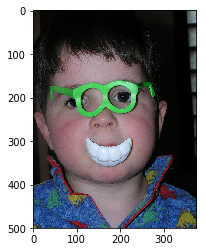

In [39]:

evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=10
)

In [ ]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=10
)

In [ ]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=50
)

In [ ]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=50
)

In [ ]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=100
)

In [ ]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=100
)